In [1]:
import tensorflow as tf
import numpy as np
from tensorflow.examples.tutorials.mnist import input_data
from utils import *
slim = tf.contrib.slim
from tqdm import tqdm_notebook as tqdm
import os 
os.environ["CUDA_VISIBLE_DEVICES"]="2"
from mnist_model import generator,discriminator
import utils

/home/data/bruno/anaconda3/envs/tf-1.4-env/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
params = dict(
    batch_size = 100,
    seed = 1234,
    z_dim = 100,
    x_dim = 784,
    reg_w = 0.,
    lr = 2e-4
)
rng = np.random.RandomState(params['seed'])  # seed labels

In [24]:
mnist = input_data.read_data_sets("MNIST_data/", one_hot=False)
trainx = np.vstack([mnist.train.images,mnist.validation.images])
trainy = np.hstack([mnist.train.labels,mnist.validation.labels])
testx = mnist.test.images
testy = mnist.test.labels
# trainx = 2.*trainx-1.
trainx = np.reshape(trainx,[-1,28,28,1])
testx = np.reshape(testx,[-1,28,28,1])
testy.astype(np.int32)
trainy.astype(np.int32)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


array([7, 3, 4, ..., 2, 1, 2], dtype=int32)

In [27]:
labeled =10000
trainx_unl = trainx.copy()
inds = np.random.permutation(trainx.shape[0])
trainx = trainx[inds]
trainy = trainy[inds]
txs = []
tys = []
for j in range(10):
    txs.append(trainx[trainy == j][:labeled])
    tys.append(trainy[trainy == j][:labeled])
txs = np.concatenate(txs, axis=0)
tys = np.concatenate(tys, axis=0)
trainx = txs
trainy = tys

nr_batch_train = trainx.shape[0] // params['batch_size']
nr_batch_test = testx.shape[0] // params['batch_size']
print(trainx.shape)

(60000, 28, 28, 1)


In [28]:
train_dataset = tf.data.Dataset.from_tensor_slices((trainx, trainy))
train_dataset = train_dataset.shuffle(10000).repeat().batch(params['batch_size'])

test_dataset = tf.data.Dataset.from_tensor_slices((testx, testy))
test_dataset = test_dataset.repeat().batch(params['batch_size'])

iterator = tf.data.Iterator.from_structure(train_dataset.output_types,
                                               train_dataset.output_shapes)
next_element, next_label = iterator.get_next()
train_triger= iterator.make_initializer(train_dataset)
test_triger= iterator.make_initializer(test_dataset)

In [29]:
def lenet(x,training_pl):
    with tf.variable_scope("classifier", reuse=tf.AUTO_REUSE):
        x = tf.reshape(x,[-1,28,28,1])
        x = tf.layers.conv2d(x,32,5,activation=tf.nn.relu,padding='same')
        x = tf.layers.max_pooling2d(x,2,2)
        x = tf.layers.conv2d(x,64,5,activation=tf.nn.relu,padding='same')
        x = tf.layers.max_pooling2d(x,2,2)
        x = tf.reshape(x, [-1, 7 * 7 * 64])
        x = tf.layers.dense(x,1024,activation=tf.nn.relu)
        x = tf.layers.dropout(x,rate=0.4,training=training_pl)
        x = tf.layers.dense(x,10)
        return x

In [32]:
label = tf.cast(next_label,tf.int64)
training_pl  = tf.placeholder(tf.bool,[])
logits = lenet(next_element,training_pl)
xloss = tf.losses.sparse_softmax_cross_entropy(logits=logits,labels=label)
with tf.variable_scope("classifier",reuse=tf.AUTO_REUSE):
    optimizer = tf.train.AdamOptimizer(learning_rate=1e-4)
    train_op = optimizer.minimize(xloss)

correct_prediction = tf.equal(tf.argmax(logits,1),label)
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))


In [36]:
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

In [37]:
sess.run(train_triger)
for i in tqdm(range(20001)):
    xl,_,acc = sess.run([xloss,train_op,accuracy],feed_dict={training_pl:True})
    if i % 2000 == 0:
        sess.run(test_triger)
        test_acc = 0
        for n in range(nr_batch_test):
            test_acc  += sess.run(accuracy,feed_dict={training_pl:False})
        test_acc /= nr_batch_test
        print("Step: {}, xloss: {:.5f}, training acc: {:.2f}%, test acc: {:.2f}%".format(i, xl, acc * 100,test_acc*100))
        sess.run(train_triger)

Step: 0, xloss: 2.35172, training acc: 0.00%, test acc: 13.62%
Step: 2000, xloss: 0.03034, training acc: 100.00%, test acc: 77.99%
Step: 4000, xloss: 0.00883, training acc: 100.00%, test acc: 83.73%
Step: 6000, xloss: 0.00048, training acc: 100.00%, test acc: 89.04%
Step: 8000, xloss: 0.00069, training acc: 100.00%, test acc: 90.31%
Step: 10000, xloss: 0.00445, training acc: 100.00%, test acc: 93.74%
Step: 12000, xloss: 0.00017, training acc: 100.00%, test acc: 95.25%
Step: 14000, xloss: 0.00192, training acc: 100.00%, test acc: 97.17%
Step: 16000, xloss: 0.01803, training acc: 99.00%, test acc: 96.83%
Step: 18000, xloss: 0.03333, training acc: 99.00%, test acc: 97.93%
Step: 20000, xloss: 0.00146, training acc: 100.00%, test acc: 96.99%



In [18]:
sess.run(test_triger)
xx,yy=sess.run([next_element,next_label])

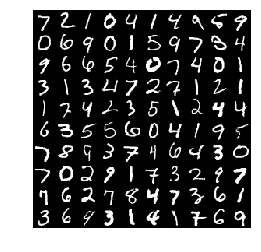

In [19]:
show_digits(xx)

In [20]:
yy

array([7, 2, 1, 0, 4, 1, 4, 9, 5, 9, 0, 6, 9, 0, 1, 5, 9, 7, 3, 4, 9, 6,
       6, 5, 4, 0, 7, 4, 0, 1, 3, 1, 3, 4, 7, 2, 7, 1, 2, 1, 1, 7, 4, 2,
       3, 5, 1, 2, 4, 4, 6, 3, 5, 5, 6, 0, 4, 1, 9, 5, 7, 8, 9, 3, 7, 4,
       6, 4, 3, 0, 7, 0, 2, 9, 1, 7, 3, 2, 9, 7, 7, 6, 2, 7, 8, 4, 7, 3,
       6, 1, 3, 6, 9, 3, 1, 4, 1, 7, 6, 9], dtype=uint8)

In [21]:
trainx.shape

(100, 28, 28, 1)